In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from atommic.collections.common.parts.transforms import EstimateCoilSensitivityMaps
from atommic.collections.common.parts import utils
from projects.reconstruction.StanfordKnees2019.scripts.preprocess_dataset import ismrmrd_to_np

In [ ]:
stanfordknees_data_dir = input("Please enter the (downloaded) data path: ")

In [5]:
filename = f'{stanfordknees_data_dir}/raw/1b197efe-9865-43be-ac24-f237c380513e.h5'

In [6]:
kspace = ismrmrd_to_np(filename)

100%|██████████| 81920/81920 [03:10<00:00, 430.64it/s]


In [7]:
imspace = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(kspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
target_rss = torch.view_as_complex(utils.coil_combination_method(utils.to_tensor(imspace), torch.empty([]), "RSS"))

In [8]:
csm_estimator = EstimateCoilSensitivityMaps(
    coil_sensitivity_maps_type="rss",
    gaussian_sigma=0.0,
    espirit_threshold=0.05,
    espirit_kernel_size=6,
    espirit_crop=0.95,
    espirit_max_iters=30,
    fft_centered=True,
    fft_normalization="ortho",
    spatial_dims=(-2, -1),
    coil_dim=0,
)

In [10]:
kspace = utils.to_tensor(kspace)
sensitivity_map = torch.stack([csm_estimator(kspace[:, slice_idx]) for slice_idx in range(kspace.shape[1])], 1)
target_sense = torch.view_as_complex(utils.coil_combination_method(utils.to_tensor(imspace), sensitivity_map, "SENSE"))

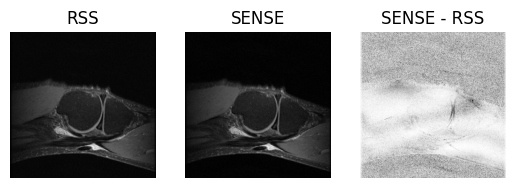

In [15]:
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(target_rss[80]), cmap='gray')
plt.title('RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(target_sense[80]), cmap='gray')
plt.title('SENSE')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(target_sense[80]) - torch.abs(target_rss[80]), cmap='gray')
plt.title('SENSE - RSS')
plt.axis('off')
plt.show()